Epoch [1/20], Train Loss: 0.5168, Train Acc: 0.8495, Test Loss: 0.2481, Test Acc: 0.9181
Epoch [2/20], Train Loss: 0.1646, Train Acc: 0.9478, Test Loss: 0.1717, Test Acc: 0.9459
Epoch [3/20], Train Loss: 0.0828, Train Acc: 0.9778, Test Loss: 0.1564, Test Acc: 0.9502
Epoch [4/20], Train Loss: 0.0499, Train Acc: 0.9865, Test Loss: 0.1506, Test Acc: 0.9538
Epoch [5/20], Train Loss: 0.0312, Train Acc: 0.9914, Test Loss: 0.1690, Test Acc: 0.9467
Epoch [6/20], Train Loss: 0.0162, Train Acc: 0.9978, Test Loss: 0.1287, Test Acc: 0.9606
Epoch [7/20], Train Loss: 0.0097, Train Acc: 0.9982, Test Loss: 0.1282, Test Acc: 0.9619
Epoch [8/20], Train Loss: 0.0058, Train Acc: 0.9997, Test Loss: 0.1258, Test Acc: 0.9623
Epoch [9/20], Train Loss: 0.0032, Train Acc: 1.0000, Test Loss: 0.1179, Test Acc: 0.9653
Epoch [10/20], Train Loss: 0.0024, Train Acc: 1.0000, Test Loss: 0.1203, Test Acc: 0.9656
Epoch [11/20], Train Loss: 0.0019, Train Acc: 1.0000, Test Loss: 0.1196, Test Acc: 0.9646
Epoch [12/20], Trai

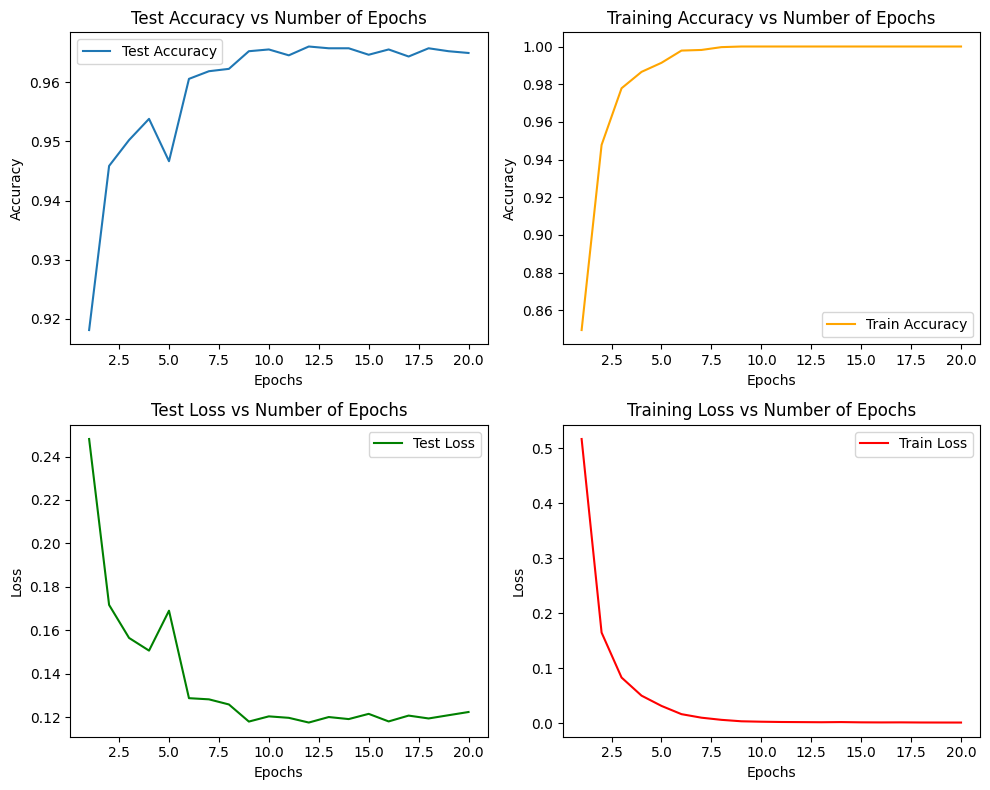

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
# Define the MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            
            nn.Linear(512, 10)
            
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        return self.layers(x)
    
# Load and preprocess the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./dataset', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./dataset', train=False, transform=transform, download=True)

subset_indices = []
for label in range(10):
    label_indices = np.where(np.array(train_dataset.targets) == label)[0]
    sampled_indices = np.random.choice(label_indices, size=600, replace=False)
    subset_indices.extend(sampled_indices)

# Create the subset
train_dataset_subset = Subset(train_dataset, subset_indices)

train_loader = DataLoader(train_dataset_subset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize the model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Training loop
num_epochs = 20


# Lists to store accuracies and losses for each epoch
train_accuracies, test_accuracies = [], []
train_losses, test_losses = [], []

# Function to calculate accuracy
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return (preds == labels).float().mean().item()

# Training and evaluation loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_train_loss = 0.0
    running_train_acc = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()
        running_train_acc += calculate_accuracy(outputs, labels)
    
    # Store average training loss and accuracy
    train_losses.append(running_train_loss / len(train_loader))
    train_accuracies.append(running_train_acc / len(train_loader))

    # Evaluation phase
    model.eval()
    running_test_loss = 0.0
    running_test_acc = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_test_loss += loss.item()
            running_test_acc += calculate_accuracy(outputs, labels)
    
    # Store average test loss and accuracy
    test_losses.append(running_test_loss / len(test_loader))
    test_accuracies.append(running_test_acc / len(test_loader))
    
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, "
          f"Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.4f}")
epochs = range(1, num_epochs + 1)

# (a) Test Accuracy vs Epochs
plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy vs Number of Epochs')
plt.legend()

# (b) Training Accuracy vs Epochs
plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs Number of Epochs')
plt.legend()

# (c) Test Loss vs Epochs
plt.subplot(2, 2, 3)
plt.plot(epochs, test_losses, label='Test Loss', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Test Loss vs Number of Epochs')
plt.legend()

# (d) Training Loss vs Epochs
plt.subplot(2, 2, 4)
plt.plot(epochs, train_losses, label='Train Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs Number of Epochs')
plt.legend()

plt.tight_layout()
plt.show()